# Image processing pipeline - tuned on library
First import the packages to set up

In [19]:
# Import necessary packages
#%pip install imutils opencv-python simplekml palettable gdown
import helper_functions as hf
import plotting as pl
import stitching as st
import gdown
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
from palettable import colorbrewer
from scipy import ndimage
from collections import Counter
from itertools import compress
cv2.ocl.setUseOpenCL(False)

In [20]:
# Variables
gdrive = False # Download data from google drive
link = 'https://drive.google.com/file/d/1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x/view?usp=sharing'
#'https://drive.google.com/file/d/1ANJ_Hq3C42Zfka_wIDX7wgbH_hwcUbGn/view?usp=sharing' # gdrive link
imgDir = 'data/120/' # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/Flight 1.csv' # Flight path .csv file
outName = 'NIAB_120'
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)','speed(mps)','isflying'] # Columns used from the path file
filters = ['altitude(m)','yaw(deg)','speed(mps)','timestamp','pitch(deg)','roll(deg)']#, 'timestamp', 'speed(mps)'] # Altitude criteria for using imagery
filtValues = [[119.7, 120.3], [-60, -50], [2.85,3.15], [1626693113971,1626693164952], [-10,10],[-10,10]]#, [1619811011923,1619811099149], [4.85,5.15]]
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
resolution = 6 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 120 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [21]:
# Download from google drive if gdrive is True
#%capture
if gdrive: 
    zippath = imgDir[:-1]+'.zip'
    downLink = link.split('/d/')[1].split('/view')[0]
    ! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
    ! unzip $zippath -d $imgDir
    ! rm $zippath

In [36]:
"""Image data assimilation functions"""
def img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType=False, corr=True):
    """Function takes image directory and a flight path .csv and merges information for each
    image according to the file name of the image which denotes a timestamp
    
    Input:
    imgDir - Directory name ending with "/" containing image files
    pathFile - File to .csv flight path from litchi application
    utcDiff - Time difference of flight info vs UTC
    imageType - True if RGB image, False if numpy array type (converted thermal images)
    
    Output:
    merged - Pandas dataframe with entry for every image containing associated flight information
    """
    
    ## Get image dataframe with corresponding properties extracted frpm path file
    fileTypes = ('.jpg','.png','.tif') if imageType else ('.npy')
    imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(fileTypes)]
    imgs.sort()
    # Extract date and time from filenames
    imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
    imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
    # Convert to unix datetime 
    imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000

    # Imprt paths and get corresponding timestamps for images
    pathDf = pd.read_csv(pathFile)
    if corr is True: corr = pathDf[pathDf['isflying']==1].iloc[-1].timestamp-imgdatetimes[-1]
    elif corr is False: corr=0
    
    # Get nearest GPS timestamp
    gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes+corr]
    
    # Create image dataframe
    imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
    imgDf['timestamp'] = imgDf['timestamp'].astype(float)

    # Merge with path dataframe
    merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
    
    return merged

## 1 - Filter images and present sample

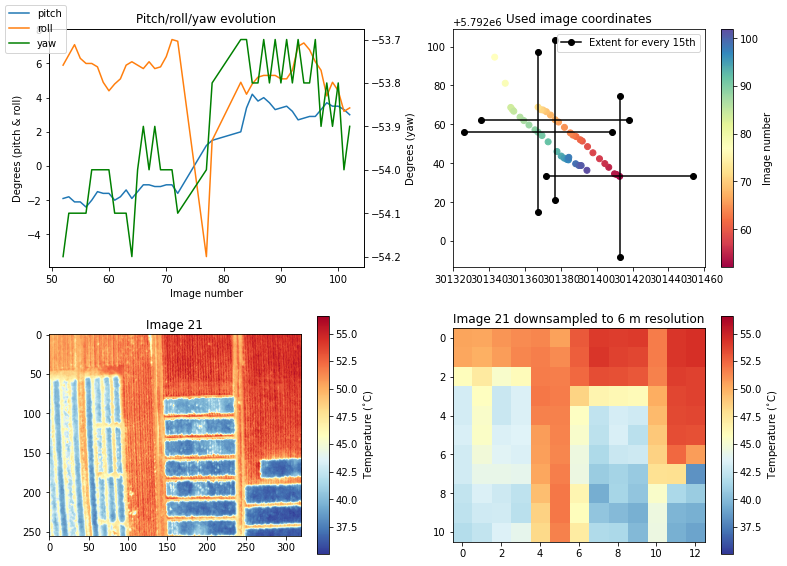

In [38]:
# Create dataframe of images associated with flight information
merged = img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType)
merged = hf.filter_imgs(merged, filters, filtValues)
merged, myProj = hf.reproject_coords(merged, utmZone, hemisphere)
idf = hf.correct_coords(merged, 20)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

## 2 - Merge according to xy coordinates

Images processed: 43it [00:02, 18.76it/s]


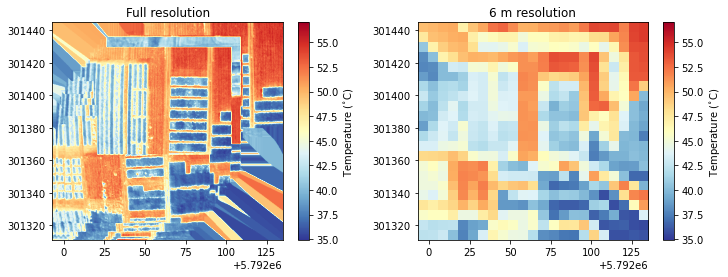

In [39]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

/home/jovyan/s4-thermal/plotting.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


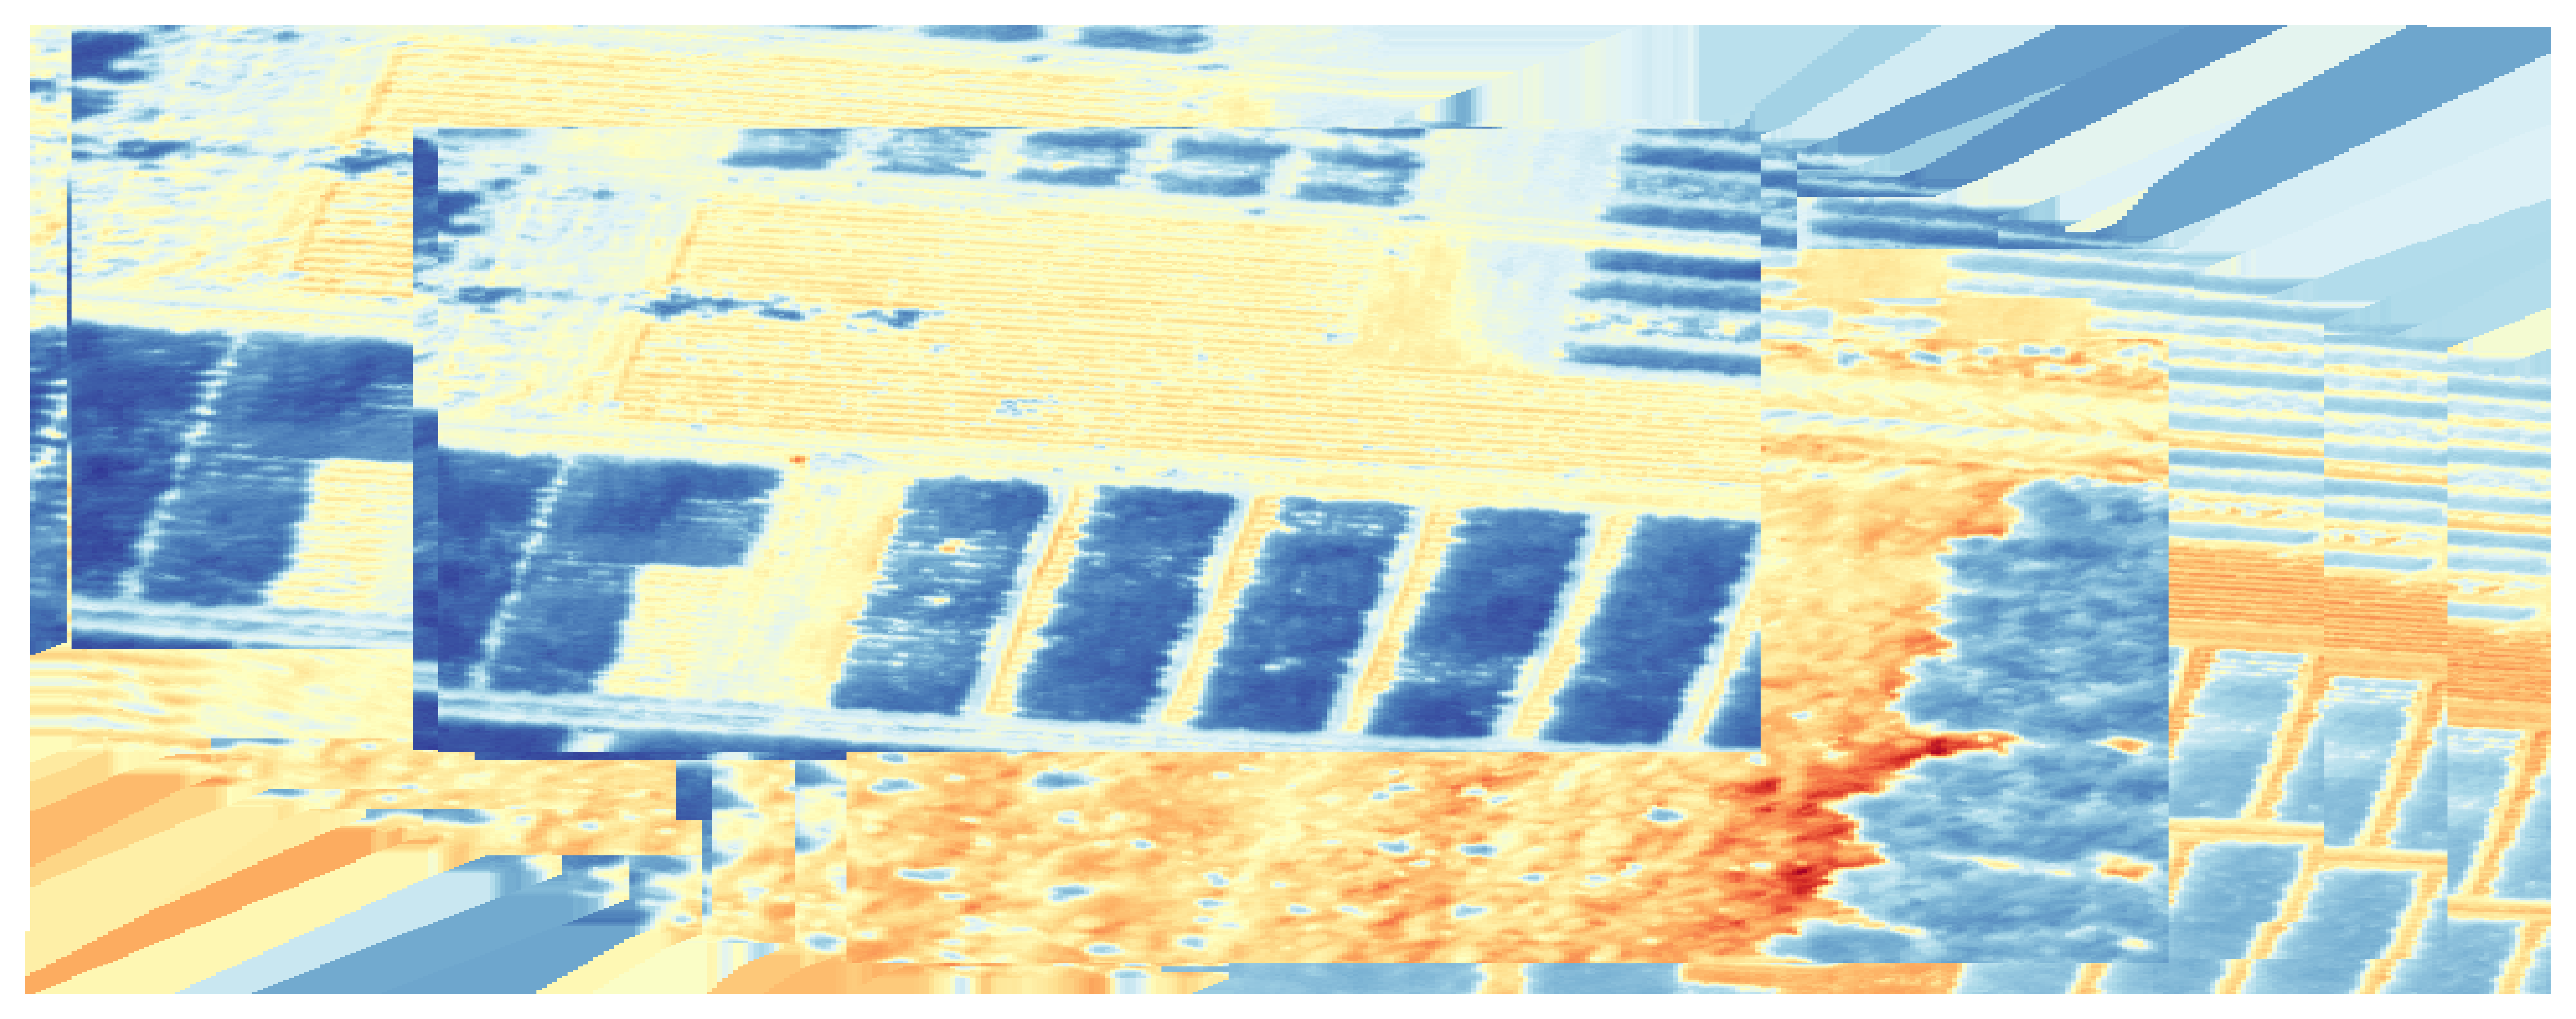

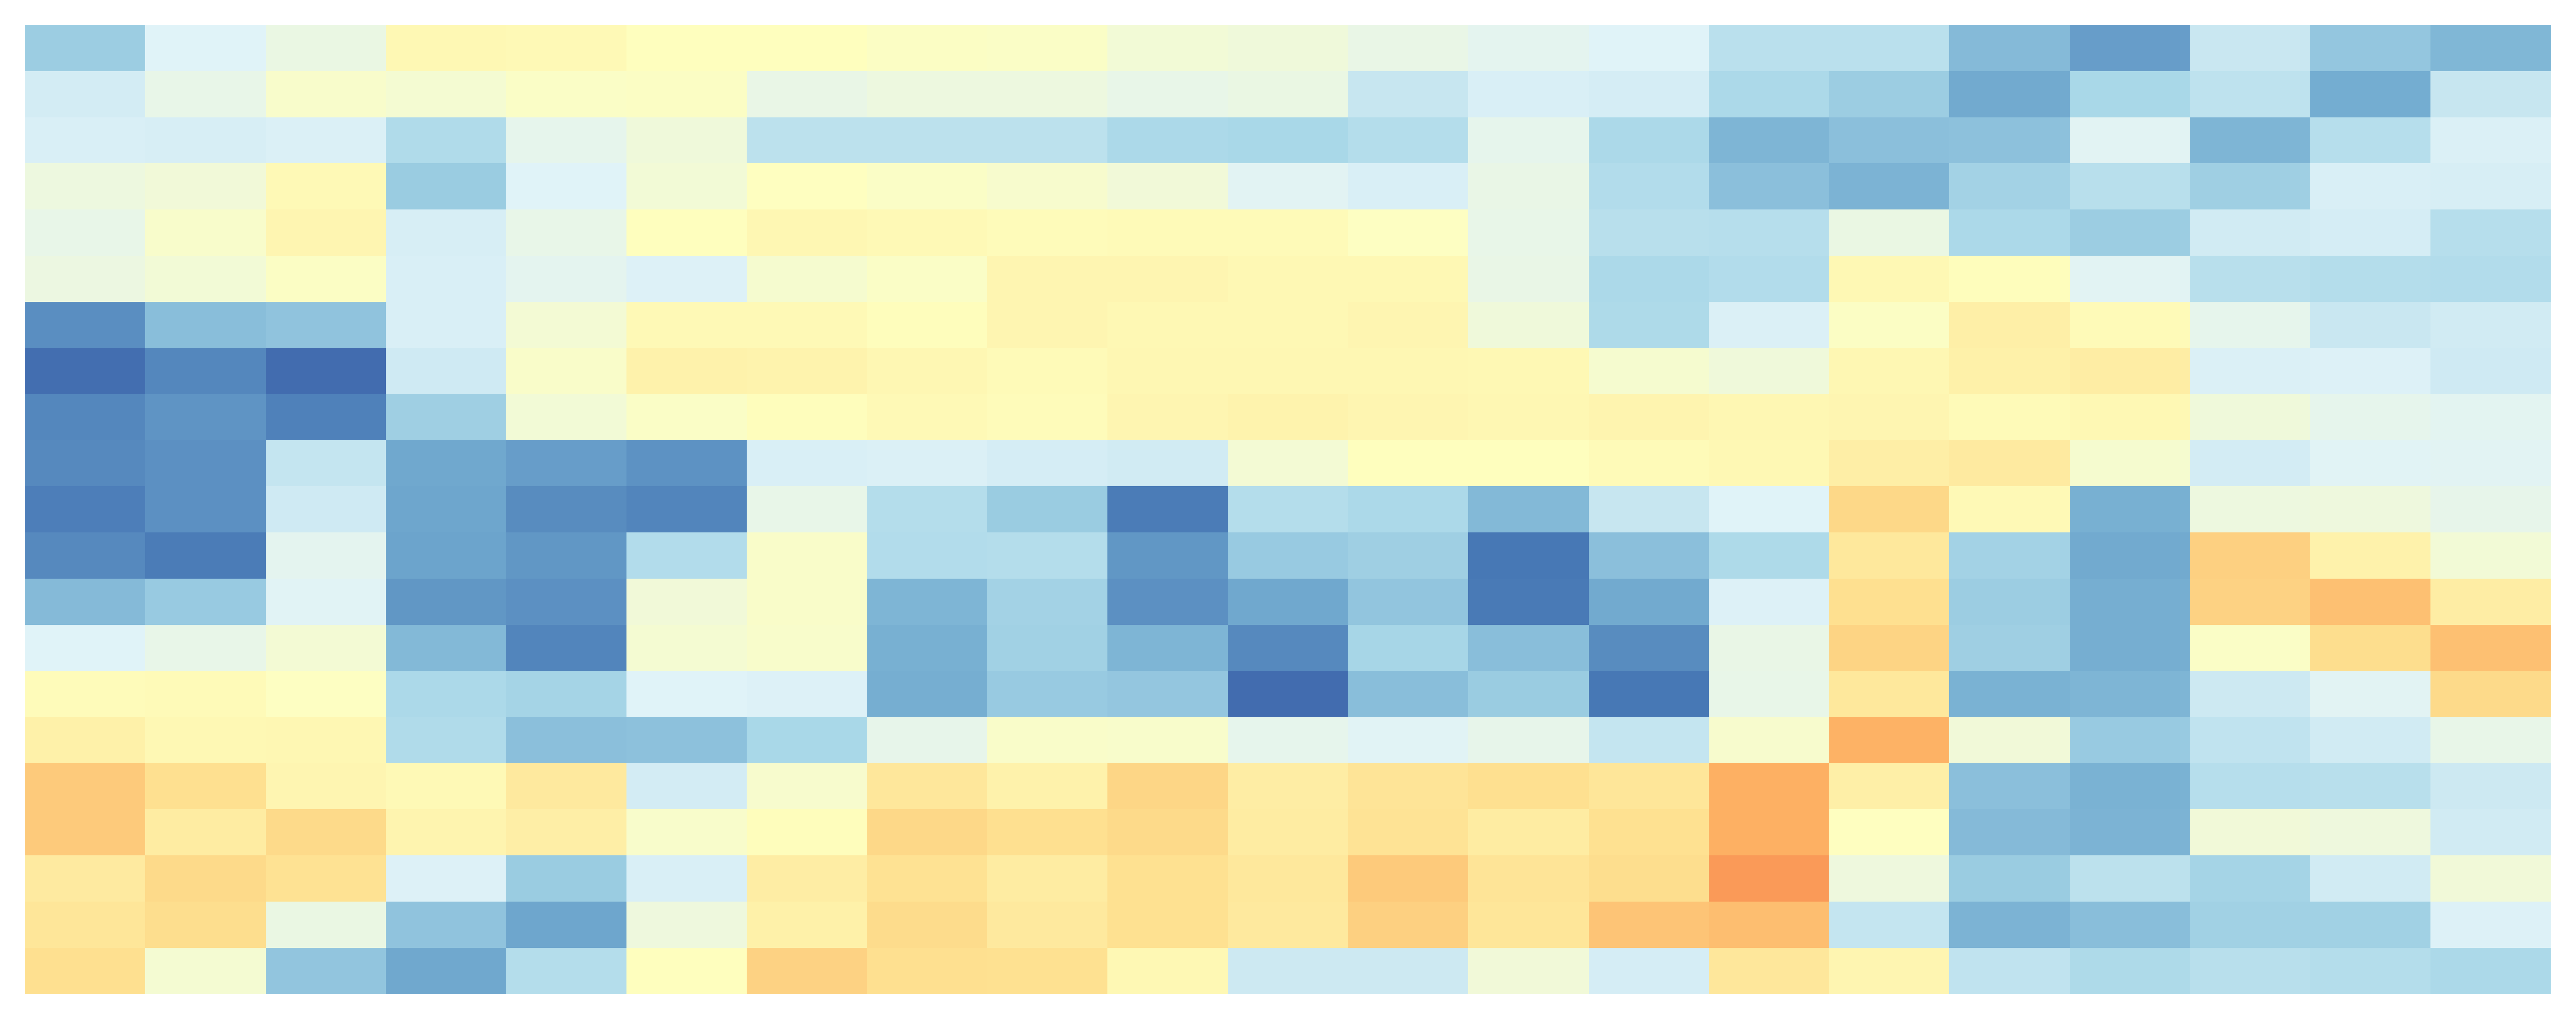

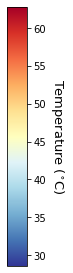

In [6]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, single = pl.plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90, cmap=cmap)
_, ds = pl.plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid, cmap=cmap)
pl.plot_kml_legend(cs, outName+'_xylegend')
pl.plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [13]:
save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

()


ValueError: Item wrong length 1 instead of 441.

## 3 - Stitch using RANSAC algorithm
Stitch each flight line into individual strip

In [125]:
# Multi-image stitching
# Setup variables
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, len(idf), 1
tmin, tmax = -10, 40
lineDist = 10
imgPath='imgPath'
skips=[]

strips = {}
# Loop over all images
while start < end-1:

    prev, single, prevImg, totalBox, prevBox = st.initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > lineDist:
            break
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
            imageio.imwrite(val,np.dstack((single,single,single)))
        # Read images - Make sure that the train image is the image that will be transformed
        trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        ma, mb, _ = st.get_img_translation(trainImg, queryImg)

        mam, mbm, diff = st.filter_img_translation(ma, mb, idf, prev, imgNum)

        totalBox, prevNew, prevImg, prevBox = st.stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, max_stdev=30, verbose=True)
        
        if prevNew < imgNum-3:
            imgNum = prevNew+1
            break
        else: prev=prevNew
        
    if start<imgNum-1: strips.update({start:prevImg})
    start = imgNum

ks = np.array(list(strips.keys()))
mn = strips[ks[0]].mean() # Get mean from first for scaling
for i in ks:
    read = ((strips[i]-strips[i].mean()+mn)*np.ma.masked_where(strips[i]!=0, strips[i]).mask).astype(np.uint8) # Rescale while keeping 0 values
    imageio.imwrite(outName+'strip'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))
    
for i in tempfiles: os.remove(i)

  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
 17%|█▋        | 7/42 [00:00<00:01, 28.89it/s]

Raw matches (Brute force): 276
Filt. matches: 2, stdev: 31.91
Images 0 and 1, poor matching
Raw matches (Brute force): 284
Filt. matches: 281, stdev: 1.61
Images 0 and 2 merged.
Raw matches (Brute force): 256
Filt. matches: 0, stdev: nan
Images 2 and 3, poor matching
Raw matches (Brute force): 222
Filt. matches: 216, stdev: 6.49
Images 2 and 4 merged.
Raw matches (Brute force): 260
Filt. matches: 255, stdev: 3.24
Images 4 and 5 merged.
Raw matches (Brute force): 279
Filt. matches: 276, stdev: 3.89
Images 5 and 6 merged.
Raw matches (Brute force): 267
Filt. matches: 261, stdev: 1.26
Images 6 and 7 merged.


 26%|██▌       | 11/42 [00:00<00:01, 30.20it/s]

Raw matches (Brute force): 262
Filt. matches: 254, stdev: 2.2
Images 7 and 8 merged.
Raw matches (Brute force): 265
Filt. matches: 258, stdev: 4.89
Images 8 and 9 merged.
Raw matches (Brute force): 282
Filt. matches: 276, stdev: 5.54
Images 9 and 10 merged.
Raw matches (Brute force): 276
Filt. matches: 271, stdev: 2.97
Images 10 and 11 merged.
Raw matches (Brute force): 265
Filt. matches: 251, stdev: 5.0
Images 11 and 12 merged.
Raw matches (Brute force): 258
Filt. matches: 242, stdev: 5.56
Images 12 and 13 merged.
Raw matches (Brute force): 284
Filt. matches: 277, stdev: 4.71
Images 13 and 14 merged.


 48%|████▊     | 20/42 [00:00<00:00, 30.38it/s]


Raw matches (Brute force): 265
Filt. matches: 258, stdev: 9.18
Images 14 and 15 merged.
Raw matches (Brute force): 282
Filt. matches: 272, stdev: 9.67
Images 15 and 16 merged.
Raw matches (Brute force): 283
Filt. matches: 275, stdev: 7.04
Images 16 and 17 merged.
Raw matches (Brute force): 296
Filt. matches: 288, stdev: 5.08
Images 17 and 18 merged.
Raw matches (Brute force): 274
Filt. matches: 266, stdev: 6.94
Images 18 and 19 merged.
Raw matches (Brute force): 277
Filt. matches: 270, stdev: 2.85
Images 19 and 20 merged.


 16%|█▌        | 3/19 [00:00<00:00, 30.95it/s]


Raw matches (Brute force): 27
Filt. matches: 11, stdev: 47.16
Images 23 and 24, poor matching
Raw matches (Brute force): 32
Filt. matches: 32, stdev: 85.89
Images 23 and 25, poor matching
Raw matches (Brute force): 32
Filt. matches: 12, stdev: 56.62
Images 23 and 26, poor matching
Raw matches (Brute force): 37
Filt. matches: 13, stdev: 61.84
Images 23 and 27, poor matching


 22%|██▏       | 4/18 [00:00<00:00, 34.88it/s]

Raw matches (Brute force): 222
Filt. matches: 8, stdev: 30.54
Images 24 and 25, poor matching
Raw matches (Brute force): 219
Filt. matches: 209, stdev: 7.79
Images 24 and 26 merged.
Raw matches (Brute force): 241
Filt. matches: 235, stdev: 3.71
Images 26 and 27 merged.
Raw matches (Brute force): 268
Filt. matches: 261, stdev: 4.69
Images 27 and 28 merged.
Raw matches (Brute force): 254
Filt. matches: 246, stdev: 3.79
Images 28 and 29 merged.
Raw matches (Brute force): 261
Filt. matches: 256, stdev: 6.97
Images 29 and 30 merged.
Raw matches (Brute force): 255
Filt. matches: 237, stdev: 7.23
Images 30 and 31 merged.


 44%|████▍     | 8/18 [00:00<00:00, 33.23it/s]

Raw matches (Brute force): 269
Filt. matches: 263, stdev: 3.11
Images 31 and 32 merged.
Raw matches (Brute force): 262
Filt. matches: 254, stdev: 11.43
Images 32 and 33 merged.
Raw matches (Brute force): 273
Filt. matches: 265, stdev: 6.48
Images 33 and 34 merged.
Raw matches (Brute force): 266
Filt. matches: 258, stdev: 8.11
Images 34 and 35 merged.


 67%|██████▋   | 12/18 [00:00<00:00, 32.40it/s]

Raw matches (Brute force): 261
Filt. matches: 251, stdev: 4.74
Images 35 and 36 merged.
Raw matches (Brute force): 268
Filt. matches: 268, stdev: 10.52
Images 36 and 37 merged.
Raw matches (Brute force): 268
Filt. matches: 75, stdev: 13.96
Images 37 and 38 merged.


100%|██████████| 18/18 [00:00<00:00, 32.32it/s]

Raw matches (Brute force): 259
Filt. matches: 251, stdev: 0.84
Images 38 and 39 merged.
Raw matches (Brute force): 257
Filt. matches: 252, stdev: 14.59
Images 39 and 40 merged.
Raw matches (Brute force): 240
Filt. matches: 228, stdev: 6.59
Images 40 and 41 merged.
Raw matches (Brute force): 253
Filt. matches: 243, stdev: 7.4
Images 41 and 42 merged.


In [126]:
strips.keys()

dict_keys([0, 24])

Find matches between strips, and filter according to corrctness with margins box.

In [127]:
# Library
#1 to 2 [290, 350, 250, 500]
#2 to 3 [500, 531.3, 380, 420]
# 3 to 4 [250, 350, 0, 500]  [500, 550, 400, 450]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Raw matches (Brute force): 252
Raw matches (Brute force): 252


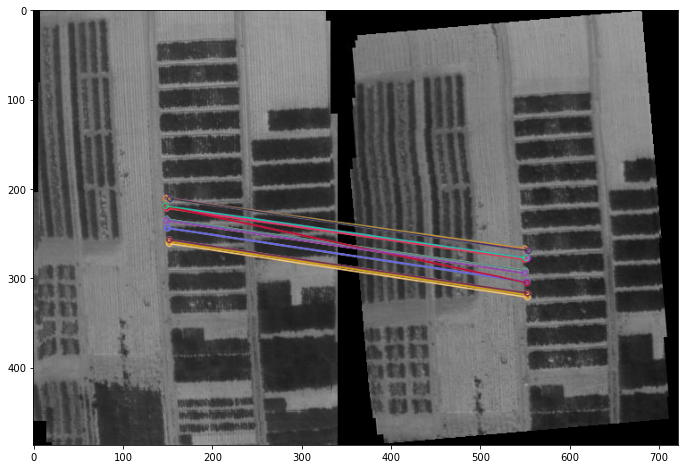

In [128]:
i, j, k = ks[0], ks[1], 'p1'
rot = 5
margins = [0,170,210,280]#[500, 550, 400, 450]
tempfiles = [outName+'strip'+str(i)+'.jpg',outName+'strip'+str(j)+'.jpg']

feature_extractor, feature_matching = 'orb', 'bf'
arrs = [hf.img_to_arr(tempfiles[0], xq=xq, yq=yq), hf.img_to_arr(tempfiles[1], xq=xq, yq=yq)]
trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
queryImg = np.ma.masked_where(ndimage.rotate(queryImg, rot)<1e-2, ndimage.rotate(queryImg, rot))

trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
elif feature_matching == 'knn':
    matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0]
                                     and kpsA[i.queryIdx].pt[0] < margins[1]
                                     and kpsA[i.queryIdx].pt[1] > margins[2]
                                     and kpsA[i.queryIdx].pt[1] < margins[3]
                                     for i in matches]))
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,100),
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

Stitch lines according to matches and an "add" adjustment of pixels.

In [129]:
# Library
# 1 to 2 [-10,]
# 2 to 3 [8,40]
# 3 to 4 [210,-75]

In [130]:
def stitch_img_result_pano(mam, mbm, diff, totalBox, prevBox, img_arrs, prevImg, prevNum, imgNum,
                           min_matches=4, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=False,inv=False):
    if verbose: print('Filt. matches: '+str(len(mam))+', stdev: ' + str(round(np.std(mam-mbm, axis=0).mean(),2)))
    # Filter for conditions
    if len(mam) > min_matches and np.std(mam-mbm, axis=0).mean() < max_stdev:
        # New box position before adjustment for expanding total box
        if rgb_query is not False:
            newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[0]+diff[1]))+rgb_query.shape[0], int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[2]+diff[0]))+rgb_query.shape[1]] 
        else: newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] 
        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        # If bounds on axis 0 go beyond total
        if newBox[0]<0 and newBox[1] > totalBox[0]:
            xmin = imgNum
            xmax = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]=newBox[1]-min(newBox[0],0)
        elif newBox[0]<0:
            xmin = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]+=abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1], newBox[0], 0
            totalBox[0]=newBox[1]
        else: modBox[0], modBox[1], pos[0] = newBox[0], newBox[1], 0#newBox[0]>0 and newBox[1] < totalBox[0]:
                 
        # If bounds on axis 1 go beyond total
        if newBox[2]<0:
            ymin = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]+=abs(newBox[2])
        if newBox[3] > totalBox[1]:
            ymax = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3], newBox[2], 0
            totalBox[1] = newBox[3]-min(newBox[2],0)
        if newBox[2]>0 and newBox[3] < totalBox[1]:
            modBox[2], modBox[3], pos[1] = newBox[2], newBox[3], 0 
        prevBox = modBox 
        
        if len(img_arrs[1].shape) == 2:
            single = (img_arrs[1]-tmin)*255/tmax
            queryImg = np.dstack((single,single,single)).astype(np.uint8)
        else: queryImg = rgb_query
        result = np.zeros([totalBox[0],totalBox[1],3])
        if inv:
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
            prevImg.data[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:] += np.array(queryImg[-min(newBox[0],0):min(queryImg.shape[0],-min(newBox[0],0)+prevImg.shape[0]),-min(newBox[2],0):min(queryImg.shape[1],-min(newBox[2],0)+prevImg.shape[1]),:]*(prevImg.mask[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:]))
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg   
        else:    
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
            print(modBox)
            print((prevImg[modBox[0]:modBox[1], modBox[2]:modBox[3],:]).shape)
            print((queryImg.mask[-min(modBox[0],0):min(modBox[1],prevImg.shape[0])-max(modBox[0],0), -min(modBox[2],0):min(modBox[3],prevImg.shape[1])-max(modBox[2],0)]).shape)
            queryImg.data[-min(modBox[0],0):min(modBox[1],prevImg.shape[0])-max(modBox[0],0), -min(modBox[2],0):min(modBox[3],prevImg.shape[1])-max(modBox[2],0)] += np.array(prevImg[modBox[0]:modBox[1], modBox[2]:modBox[3],:]*(queryImg.mask[-min(modBox[0],0):min(modBox[1],prevImg.shape[0])-max(modBox[0],0), -min(modBox[2],0):min(modBox[3],prevImg.shape[1])-max(modBox[2],0)]))
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prevNum),str(imgNum)))
        prevNum, prevImg = imgNum, result
    else: print('Images {} and {}, poor matching'.format(str(prevNum),str(imgNum)))
    return totalBox, prevNum, prevImg, prevBox

Filt. matches: 18, stdev: 3.61
Images 0 and 1 merged.


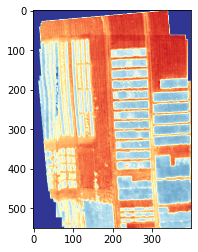

In [131]:
adds = [2,-5]#[210,-75]
# Potential to improve by filtering out matches that are not in same direction of travel as drone
ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matchesUsed]])
mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matchesUsed]])
diff = np.median(ma-mb, axis=0).astype(int)+adds#+[50,-140]
totalBox=[trainImg.shape[0], trainImg.shape[1]]
prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

totalBox, prevNew, prevImg, prevBox = stitch_img_result_pano(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum=0, imgNum=1,
                      min_matches=0, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=queryImg, inv=True)

plt.imshow(prevImg.mean(axis=2),cmap=cmap)
single = prevImg.mean(axis=2).astype(np.uint8)
imageio.imwrite('lib_strips/'+k+'.jpg',np.dstack((single,single,single)))   

In [146]:
def plot_kml(arr, conv, name, pixels, rot=False, scale=False, temp=True, tmin=0, tmax=40,cmap='hot', add_temp=0):
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                            urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                            pixels=pixels)
    if len(arr.shape) > 2: arr = arr.mean(axis=2)
    if rot is not False: arr = np.ma.masked_where(ndimage.rotate(arr, rot)<(1e-2), ndimage.rotate(arr, rot))
    single =  arr if temp else np.ma.masked_where(arr/255*tmax+tmin < tmin+5, arr/255*tmax+tmin)
    if scale is False: scale = single+add_temp
    cs = ax.imshow(single+add_temp,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=scale.min(),vmax=scale.max())
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)
    return cs, single
    
def plot_kml_legend(cs, name, label='Temperature ($^{\circ}$C)'):
    fig = plt.figure(figsize=(1.0, 4.0))
    ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
    cb = fig.colorbar(cs, cax=ax)
    cb.set_label(label, rotation=-90, color='k', labelpad=20, fontsize=13)
    fig.tight_layout()
    fig.savefig(name+'.png', format='png', bbox_inches = 'tight', pad_inches = 0.2)

/home/jovyan/s4-thermal/plotting.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


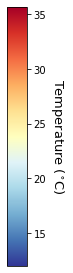

In [147]:
# Save as .kmz file
result = np.ma.masked_where(np.dstack((single,single,single))==0, np.dstack((single,single,single)))
extent = [] # Auto get coords from idf
inputCoords = np.array([[0.089534, 0.092050],[52.242445, 52.243700]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, first = plot_kml(result.data, conv, outName+'_stitch', 1024*10, rot=90+idf['yaw(deg)'].mean()+10, temp=False, tmin=tmin, tmax=tmax,cmap=cmap, add_temp=17)
_, ds = plot_kml(hf.downsample_arr(first,pxSize,resolution), conv, outName+'_ds_stitch', 1024*10, rot=0, scale=first, cmap=cmap)
pl.plot_kml_legend(cs, outName+'_stitchlegend')
pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)
pl.make_kml(conv, figs=[outName+'_stitch.png', outName+'_ds_stitch.png', outName+'_stitchpath.png'], 
            colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_thermal.kmz',
            description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

In [296]:
save_to_csv(first, ds, conv, pxSize, resolution, outName+'_stitch', single=True)

In [291]:
# Save as .csv file
def save_to_csv(arr1, arr2, conv, res1, res2, name, single=False):
    arr_s = arr1.shape
    ptslon = np.linspace(conv[0].min(),conv[0].max(),arr_s[1]+1)[:-1]
    ptslon += (ptslon[1]-ptslon[0])/2
    ptslat = np.linspace(conv[1].min(),conv[1].max(),arr_s[0]+1)[:-1]
    ptslat += (ptslat[1]-ptslat[0])/2
    lonm, latm = np.meshgrid(ptslon,ptslat)
    if single: tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)'])
    else:
        ds_q = int(np.floor(res1/res2))
        if ds_q>1:
            arr_mod = np.round(arr2[:-(arr2.shape[0] % ds_q),:-(arr2.shape[1] % ds_q)]).astype(int)
            most=np.zeros([len(range(0,arr_mod.shape[0]-ds_q,ds_q))+1, len(range(0,arr_mod.shape[1]-ds_q,ds_q))+1])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    most[int(i/ds_q),int(j/ds_q)] = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        else:
            ds_q = int(np.floor(res2/res1))
            arr_mod = np.round(arr1[:-(arr1.shape[0] % ds_q),:-(arr1.shape[1] % ds_q)]).astype(int)
            most=np.zeros([arr1.shape[0], arr1.shape[1]])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    #print(Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0])
                    ct = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
                    most[int(i/ds_q):int(i/ds_q)+ds_q,int(j/ds_q):int(j/ds_q)+ds_q] = np.array([[ct for y in range(ds_q)] for x in range(ds_q)]) if ct is None else np.array([[ct for y in range(ds_q)] for x in range(ds_q)]).astype(int)

        tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)', str(round(res2, 2))+'m T(C)'])
    filt = tdf[arr1.mask.reshape(-1,1) == False]
    filt.to_csv(name+'.csv', index_label='UID')